<a href="https://colab.research.google.com/github/haryobimo96/ct-denoising-redcnn/blob/master/CT_RED_CNN_Reconstructor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Libraries

In [1]:
pip install pydicom

     |████████████████████████████████| 35.5MB 87kB/s 


In [2]:
import numpy as np
import tensorflow as tf
import pydicom as dicom
from tensorflow.keras.models import load_model
from matplotlib import pyplot

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Extract the saved model's weight

In [7]:
!unzip model_weight.zip -d '/content/'

Archive:  model_weight.zip
   creating: /content/content/mymodel/
  inflating: /content/content/mymodel/saved_model.pb  
   creating: /content/content/mymodel/variables/
  inflating: /content/content/mymodel/variables/variables.data-00000-of-00001  
  inflating: /content/content/mymodel/variables/variables.index  
   creating: /content/content/mymodel/assets/


In [8]:
model = tf.keras.models.load_model('/content/content/mymodel')

# 3. Initiate the patch denoising and reconstruction process

In [9]:
class FileManager():

    def __init__(self,directory):
        self.directory = directory

    def DicomFiles(self):
        PathDicom = self.directory
        lstFilesDCM = []
        for dirName, subdirList, fileList in os.walk(PathDicom):
            for filename in sorted(fileList):
                if ".dcm" in filename.lower():
                    lstFilesDCM.append(os.path.join(dirName,filename))
        return lstFilesDCM

    def FileCounter(self):
        file_count = sum(len(files) for _, _, files in 
                         sorted(os.walk(self.directory)))
        return file_count

In [10]:
class ImageReconstructor():
  
    def __init__(self,img,pixel_size,patch_size,patch_stride):
        self.img = img
        self.pixel_size = pixel_size
        self.patch_size = patch_size
        self.patch_stride = patch_stride
    
    def patch_extractor(self):
        patches = int(((self.pixel_size-self.patch_size
                        )/(self.patch_stride))**2)
        patch_array = np.zeros((int(patches),
                                self.patch_size,self.patch_size),
                               dtype='float32')
        for j in range(0,self.pixel_size-self.patch_size,self.patch_stride):
            for i in range(0,self.pixel_size-self.patch_size,self.patch_stride):
                patch_array[int(i/self.patch_stride)
                + int(j*np.sqrt(patches)/self.patch_stride)
                ] = self.img[i:i+self.patch_size, j:j+self.patch_size]
        return patch_array

    def patch_reconstructor(self,array):
        array = array.reshape(array.shape[0],array.shape[1],array.shape[2],1)
        patches = int(((self.pixel_size-self.patch_size
                        )/(self.patch_stride))**2)
        tp = []
        divpatch = np.full((self.patch_size,self.patch_size),1)
        divisor = np.zeros((self.pixel_size,self.pixel_size,1), 
                           dtype = 'float32')
        ip = np.zeros((self.pixel_size, self.pixel_size, 1), dtype = 'uint16')
        mean1 = np.mean(np.array([array[6000]]))

        for k in range(0, patches):
            x = model.predict(array[k].reshape(1,self.patch_size,
                                               self.patch_size, 1))
            tp.append(x)
            
        for j in range(0, self.pixel_size-self.patch_size, self.patch_stride):
            for i in range(0, self.pixel_size-self.patch_size,
                           self.patch_stride):
                b = np.array(tp[int(i/self.patch_stride
                                    )+int(j/self.patch_stride)
                                    *int(np.sqrt(patches)
                                    )].reshape(self.patch_size,
                                               self.patch_size))
                a = np.pad(b,((int(i),self.pixel_size-(int(i)+self.patch_size)),
                              (int(j),self.pixel_size-(int(j)+self.patch_size))
                              ), mode = 'constant')
                divisorpad = np.pad(divpatch,
                                    ((int(i),self.pixel_size
                                      -(int(i)+self.patch_size)),
                                     (int(j),self.pixel_size-
                                      (int(j)+self.patch_size))),
                                    mode = 'constant')
                a = a.reshape(self.pixel_size, self.pixel_size, 1)
                divisorpad = divisorpad.reshape(self.pixel_size,
                                                self.pixel_size,1)
                ip = ip + a
                divisor = divisor + divisorpad

        ipfinal = ip/divisor
        mean2 = np.mean(np.array([ipfinal[220:300,220:300]]))
        ipfinal = ipfinal*mean1/mean2
        return ipfinal

In [ ]:
tp = [np.zeros((patches, self.patch_size, self.patch_size, 1),
                      dtype = 'float32')]

# 4. Read and execute the file

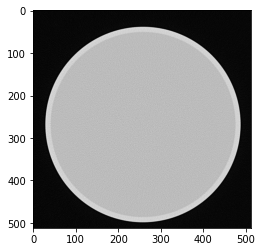

In [11]:
ds = dicom.read_file('/content/200 mAs.dcm')
img = ds.pixel_array
pyplot.imshow(img,cmap='gray')

In [12]:
I = ImageReconstructor(img, 512, 64, 4)
It =  I.patch_extractor()

In [13]:
imgt = I.patch_reconstructor(It)
ds.PixelData = imgt.astype('uint16').tobytes()
ds.save_as('HASIL_200mAs.dcm')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide


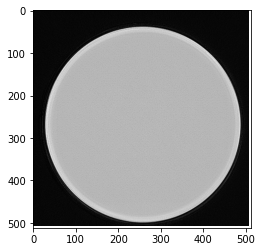

In [14]:
pyplot.imshow(imgt.reshape(512,512),cmap='gray')